# LSTM Implementation

## Imports

In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

##  Loading and Preprocessing Data
- Load Dataset
- Convert Timestamps
- Select Target Variable
- Normalize Target Variable

In [6]:
# Set Global Random Seed for Reproducibility
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
file_path = 'data/germany_cleaned_load_data.csv'
data = pd.read_csv(file_path)

# Convert timestamps to datetime
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data.set_index('utc_timestamp', inplace=True)

# Select Target Variable
target_column = 'DE_load_actual_entsoe_transparency'
target_data = data[[target_column]]  # Keep as DataFrame

# Normalise Target Variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_data_scaled = scaler.fit_transform(target_data)

print(f"Dataset Shape: {target_data.shape}")

Dataset Shape: (43824, 1)


## Data Splitting and Sequence Preparation
- Split Data into Train (70%), Validation (15%), and Test (15%)
- Create Sequences for Time-Series Forecasting
- Reshape Data for LSTM Input

In [7]:
# Split Data into Train (70%), Temp (30%) → Then Split Temp into Validation (15%) & Test (15%)
train_ratio = 0.7
train_data, temp_data = train_test_split(target_data_scaled, train_size=train_ratio, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

print(f"Train Size: {len(train_data)}, Validation Size: {len(val_data)}, Test Size: {len(test_data)}")

# Function to Create Sequences for Time-Series Forecasting
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])  # Past `time_steps` values
        y.append(data[i + time_steps])      # Target value at next step
    return np.array(X), np.array(y)

# Define Sequence Length (e.g., last 24 hours → predict next hour)
time_steps = 24

# Create Sequences for Train, Validation, and Test Sets
X_train, y_train = create_sequences(train_data, time_steps)
X_val, y_val = create_sequences(val_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Reshape Data for LSTM Input (Samples, Time Steps, Features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Train Sequences: {X_train.shape}, Train Labels: {y_train.shape}")
print(f"Validation Sequences: {X_val.shape}, Validation Labels: {y_val.shape}")
print(f"Test Sequences: {X_test.shape}, Test Labels: {y_test.shape}")

Train Size: 30676, Validation Size: 6574, Test Size: 6574
Train Sequences: (30652, 24, 1), Train Labels: (30652, 1)
Validation Sequences: (6550, 24, 1), Validation Labels: (6550, 1)
Test Sequences: (6550, 24, 1), Test Labels: (6550, 1)


## Simple Baseline Model

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0700 - val_loss: 0.0047
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Final Test MAPE: 0.0213
Final Test MAE: 1117.9721
Final Test RMSE: 1426.9169
Final Test R² Score: 0.9782


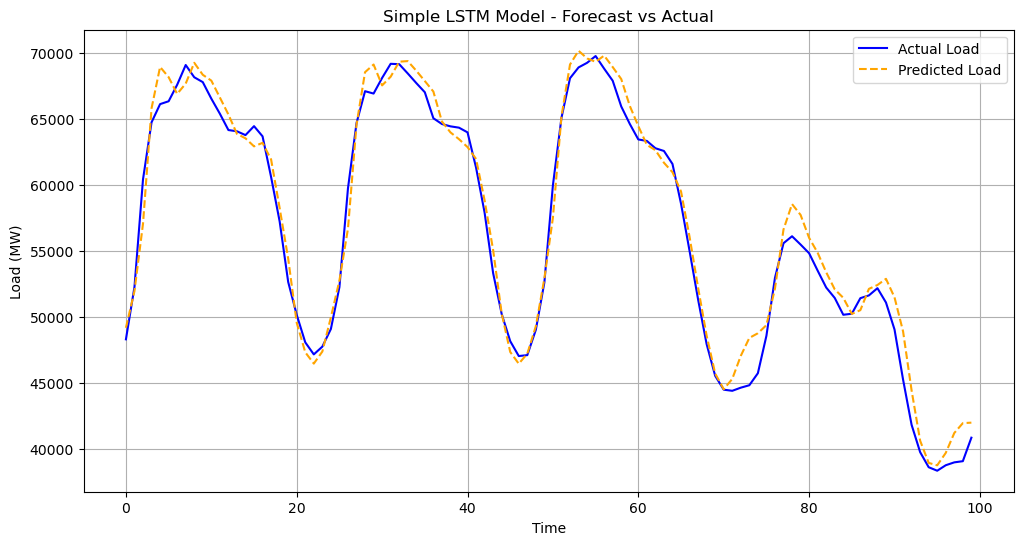

In [8]:
def build_simple_lstm(input_shape):
    model = Sequential([
        LSTM(units=10, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train model
input_shape = (X_train.shape[1], X_train.shape[2])
simple_lstm = build_simple_lstm(input_shape)
simple_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict
test_predictions = simple_lstm.predict(X_test)

# Inverse transform predictions and actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(test_predictions)

# Evaluate
test_mape = mape(y_test_actual, y_pred_actual)
test_mae = mean_absolute_error(y_test_actual, y_pred_actual)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
test_r2 = r2_score(y_test_actual, y_pred_actual)

# Print evaluation results
print(f"\nFinal Test MAPE: {test_mape:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:100], label="Actual Load", color="blue")
plt.plot(y_pred_actual[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Simple LSTM Model - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## 50 Units

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0275 - val_loss: 0.0019
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0011 - val_loss: 8.8942e-04
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.8265e-04 - val_loss: 8.1143e-04
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.1122e-04 - val_loss: 7.7136e-04
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Final Test MAPE: 0.0179
Final Test MAE: 937.9285
Final Test RMSE: 1233.0835
Final Test R² Score: 0.9838


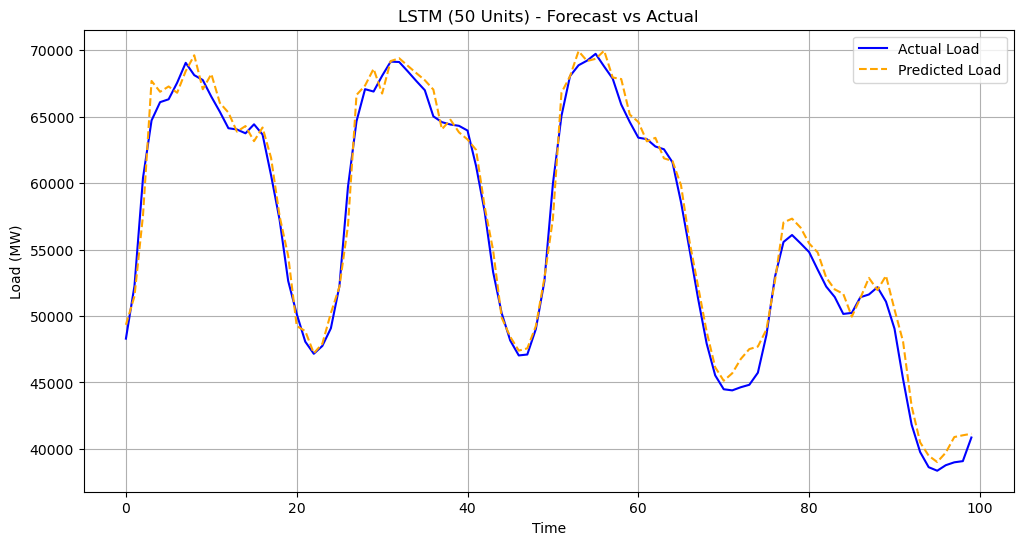

In [ ]:
def build_lstm_with_50_units(input_shape):
    model = Sequential([
        LSTM(units=50, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train model
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_50 = build_lstm_with_50_units(input_shape)

lstm_50.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict on test data
test_predictions = lstm_50.predict(X_test)

# Inverse transform both test labels and predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)

# Evaluate
test_mape = mape(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nFinal Test MAPE: {test_mape:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

# Plot first 100 values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("LSTM (50 Units) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## 20% Dropout

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0323 - val_loss: 0.0031
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0021 - val_loss: 8.3908e-04
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0016 - val_loss: 8.0625e-04
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Final Test MAPE: 0.0169
Final Test MAE: 899.5950
Final Test RMSE: 1229.1090
Final Test R² Score: 0.9839


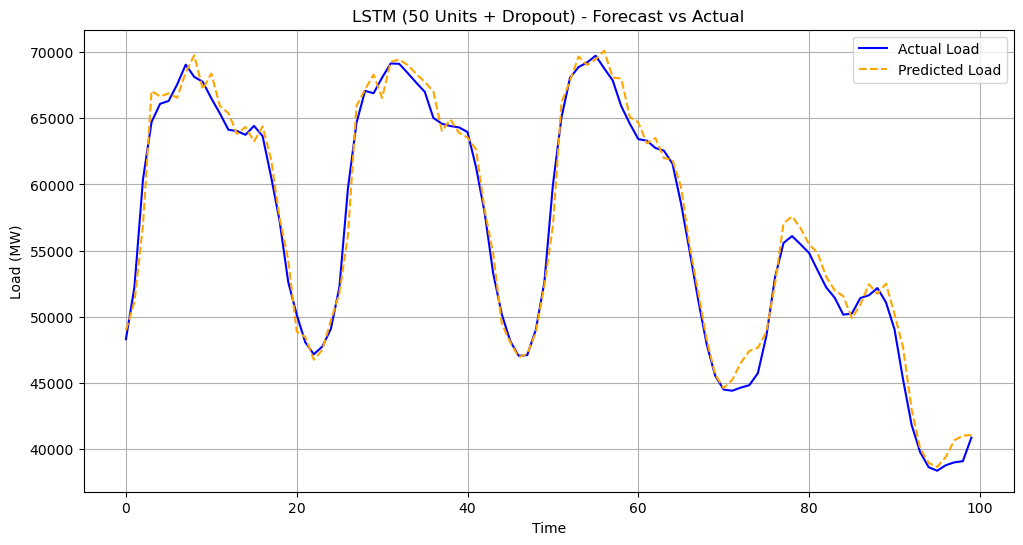

In [ ]:
def build_lstm_with_dropout(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train the model
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_dropout = build_lstm_with_dropout(input_shape)

lstm_dropout.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict
test_predictions = lstm_dropout.predict(X_test)

# Inverse transform both test labels and predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)

# Evaluate
test_mape = mape(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nFinal Test MAPE: {test_mape:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("LSTM (50 Units + Dropout) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## 10% Dropout

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0199 - val_loss: 0.0019
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0018 - val_loss: 7.8077e-04
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0014 - val_loss: 7.6325e-04
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0013 - val_loss: 7.2514e-04
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Final Test MAPE: 0.0162
Final Test MAE: 852.5854
Final Test RMSE: 1168.8060
Final Test R² Score: 0.9854


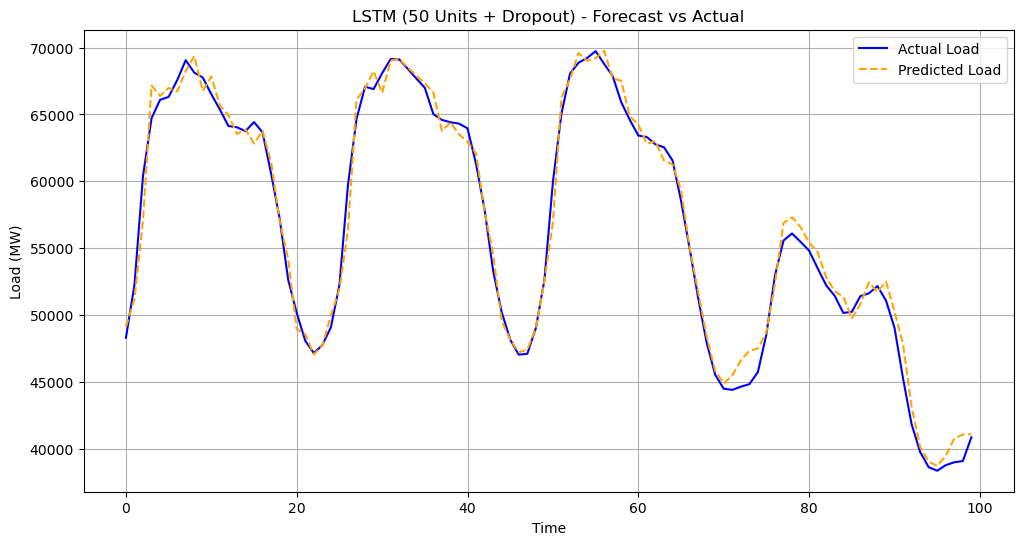

In [9]:
# Define LSTM model with Dropout
def build_lstm_with_dropout(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=False, input_shape=input_shape),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train the model
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_dropout = build_lstm_with_dropout(input_shape)

lstm_dropout.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict
test_predictions = lstm_dropout.predict(X_test)

# Inverse transform both test labels and predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)

# Evaluate
test_mape = mape(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nFinal Test MAPE: {test_mape:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("LSTM (50 Units + Dropout) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()